In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import gpxpy.gpx
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.style.use("fivethirtyeight")
import setup
import data_tools as tls

In [2]:
tree = ET.parse("data/apple_health_export/export.xml")
root = tree.getroot()

In [4]:
wk = setup.create_df("Workout")
wk = setup.clean_workout_df(wk)
wk.type.unique()

array(['TraditionalStrengthTraining', 'Cycling', 'Running',
       'CoreTraining', 'Walking', 'Tennis', 'Swimming'], dtype=object)

In [5]:
rec = setup.create_df("Record")
rec = setup.clean_record_df(rec)

In [6]:
rec.type.unique()

array(['Height', 'BodyMass', 'HeartRate', 'RespiratoryRate', 'StepCount',
       'DistanceWalkingRunning', 'BasalEnergyBurned',
       'ActiveEnergyBurned', 'FlightsClimbed', 'AppleExerciseTime',
       'DistanceSwimming', 'SwimmingStrokeCount', 'RestingHeartRate',
       'VO2Max', 'WalkingHeartRateAverage', 'HeadphoneAudioExposure',
       'WalkingDoubleSupportPercentage', 'SixMinuteWalkTestDistance',
       'AppleStandTime', 'WalkingSpeed', 'WalkingStepLength',
       'WalkingAsymmetryPercentage', 'SleepDurationGoal',
       'AppleWalkingSteadiness', 'SleepAnalysis', 'AppleStandHour',
       'MindfulSession', 'HeartRateVariabilitySDNN'], dtype=object)

In [30]:
hr = setup.filter_type(rec, 'HeartRate')
running = setup.filter_type(wk, 'Running')
hrs = tls.get_heartrate_for_workout(hr, running.loc[[179]])
minh = hrs['value'].min()
maxh = hrs['value'].max()
meanh = hrs['value'].mean()
print(running.loc[[179]].type.item(), minh, maxh, meanh)

Running 128.0 195.0 180.45238095238096


## Records

In [8]:
record_list = [x.attrib for x in root.iter('Record')]
record_df = pd.DataFrame(record_list)

In [9]:
# to datetime
for col in ['creationDate', 'startDate', 'endDate']:
    record_df[col] = pd.to_datetime(record_df[col])
    
# value to numeric or nan
record_df['value'] = pd.to_numeric(record_df['value'], errors='coerce')
record_df['value'] = record_df['value'].fillna(1.0)

# shorter abbreviations
record_df['type'] = record_df['type'].str.replace('HKQuantityTypeIdentifier', '')
record_df['type'] = record_df['type'].str.replace('HKCategoryTypeIdentifier', '')
record_df['type'] = record_df['type'].str.replace('HKDataType', '')

In [10]:
record_df.loc[record_df['sourceName'] == 'Marlon’s Apple\xa0Watch', 'sourceName'] = "Apple Watch"
record_watch_df = record_df.loc[record_df['sourceName'] == 'Apple Watch']

In [11]:
record_df.type.unique()

array(['Height', 'BodyMass', 'HeartRate', 'RespiratoryRate', 'StepCount',
       'DistanceWalkingRunning', 'BasalEnergyBurned',
       'ActiveEnergyBurned', 'FlightsClimbed', 'AppleExerciseTime',
       'DistanceSwimming', 'SwimmingStrokeCount', 'RestingHeartRate',
       'VO2Max', 'WalkingHeartRateAverage', 'HeadphoneAudioExposure',
       'WalkingDoubleSupportPercentage', 'SixMinuteWalkTestDistance',
       'AppleStandTime', 'WalkingSpeed', 'WalkingStepLength',
       'WalkingAsymmetryPercentage', 'SleepDurationGoal',
       'AppleWalkingSteadiness', 'SleepAnalysis', 'AppleStandHour',
       'MindfulSession', 'HeartRateVariabilitySDNN'], dtype=object)

## Workouts

In [12]:
workout_list = [x.attrib for x in root.iter('Workout')]
workout_df = pd.DataFrame(workout_list)

In [13]:
workout_df['workoutActivityType'] = workout_df['workoutActivityType'].str.replace('HKWorkoutActivityType', '')
workout_df = workout_df.rename({"workoutActivityType": "Type"}, axis=1)

# to datetime
for col in ['creationDate', 'startDate', 'endDate']:
    workout_df[col] = pd.to_datetime(workout_df[col])

# string to numeric
workout_df['duration'] = pd.to_numeric(workout_df['duration'])
workout_df['totalEnergyBurned'] = pd.to_numeric(workout_df['totalEnergyBurned'])
workout_df['totalDistance'] = pd.to_numeric(workout_df['totalDistance'])

In [14]:
workout_df.loc[workout_df['sourceName'] == 'Marlon’s Apple\xa0Watch', 'sourceName'] = "Apple Watch"
##workout_watch_df = workout_df.loc[workout_df['sourceName'] == 'Apple Watch']

In [15]:
num_workouts = workout_df.shape[0]
workout_df.Type.unique()

array(['TraditionalStrengthTraining', 'Cycling', 'Running',
       'CoreTraining', 'Walking', 'Tennis', 'Swimming'], dtype=object)

In [16]:
def get_workouts(df, workout_type):
    return df[df['Type'] == workout_type]

running_df = get_workouts(workout_df, "Running")

In [17]:
def get_workouts_from_to(df, start, end):
    start = pd.to_datetime(start, utc=True)
    end = pd.to_datetime(end, utc=True)
    workouts = df[df['creationDate'] >= start]
    workouts = workouts[workouts['creationDate'] <= end]
    
    return workouts

lower_time = dt.date(2020, 1, 1)
upper_time = dt.date.today()
workouts = get_workouts_from_to(workout_df, lower_time, upper_time)

In [18]:
def get_heartrate_for_workout(heartrate, workout):
    def get_heartrate_for_date(hr, start, end):
        hr = hr[hr['startDate'] >= start]
        hr = hr[hr['endDate'] <= end]
        
        return hr
    
    return get_heartrate_for_date(heartrate, workout['startDate'].item(), workout['endDate'].item())

heartrate_df = record_df[record_df['type'] == 'HeartRate']

running_workout = running_df.loc[[179]]
heartrate_workout = get_heartrate_for_workout(heartrate_df, running_workout)
minh = heartrate_workout['value'].min()
maxh = heartrate_workout['value'].max()
meanh = heartrate_workout['value'].mean()
print(running_workout.Type.item(), minh, maxh, meanh)

Running 128.0 195.0 180.45238095238096


In [19]:
def remove_outliers(df,columns,n_std):
    for col in columns:
        #print('Working on column: {}'.format(col))
        
        mean = df[col].mean()
        sd = df[col].std()
        
        df = df[(df[col] <= mean+(n_std*sd))]
        
    return df

<AxesSubplot:xlabel='duration', ylabel='totalEnergyBurned'>

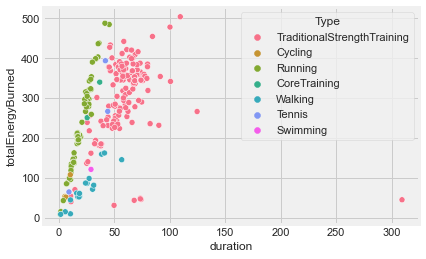

In [20]:
workout_df = remove_outliers(workout_df, ['duration', 'totalEnergyBurned'], 2)
sns.scatterplot(data=workout_df, x='duration', y='totalEnergyBurned', hue='Type')

<AxesSubplot:xlabel='endDate'>

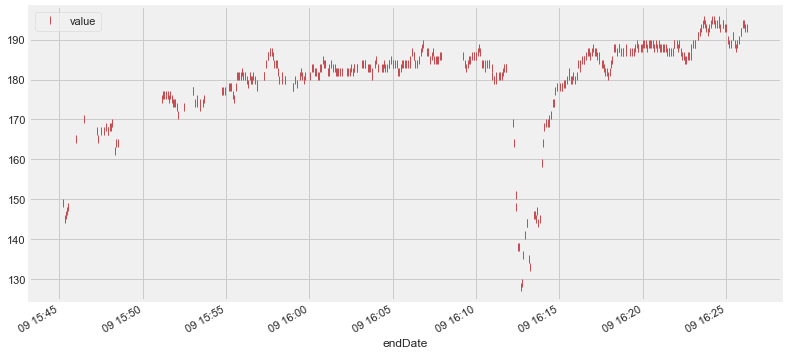

In [21]:
heartrate_workout.plot(x='endDate', y='value', style='r|', markersize=7.5, figsize=(12,6))

In [22]:
workout_df.head()

,Type,duration,durationUnit,totalDistance,totalDistanceUnit,totalEnergyBurned,totalEnergyBurnedUnit,sourceName,sourceVersion,device,creationDate,startDate,endDate
1,TraditionalStrengthTraining,28.767217,min,0.0,mi,161.977679,Cal,Apple Watch,6.1.1,"<<HKDevice: 0x280264870>, name:Apple Watch, ma...",2020-01-19 11:18:01-07:00,2020-01-19 10:49:11-07:00,2020-01-19 11:17:58-07:00
2,TraditionalStrengthTraining,14.311157,min,0.0,mi,70.615763,Cal,Apple Watch,6.1.1,"<<HKDevice: 0x280264870>, name:Apple Watch, ma...",2020-01-19 11:32:19-07:00,2020-01-19 11:17:58-07:00,2020-01-19 11:32:17-07:00
3,TraditionalStrengthTraining,100.048343,min,0.0,mi,477.992920,Cal,Apple Watch,6.1.1,"<<HKDevice: 0x280264870>, name:Apple Watch, ma...",2020-01-24 23:19:22-07:00,2020-01-24 21:39:12-07:00,2020-01-24 23:19:15-07:00
4,TraditionalStrengthTraining,27.227527,min,0.0,mi,218.123682,Cal,Apple Watch,6.1.1,"<<HKDevice: 0x280264870>, name:Apple Watch, ma...",2020-01-29 11:29:51-07:00,2020-01-29 10:29:53-07:00,2020-01-29 11:29:48-07:00
5,Cycling,5.234233,min,0.0,mi,53.292402,Cal,Apple Watch,6.1.1,"<<HKDevice: 0x280264870>, name:Apple Watch, ma...",2020-02-04 12:16:43-07:00,2020-02-04 12:11:27-07:00,2020-02-04 12:16:41-07:00


## Workout Event

In [23]:
workoutEvent_list = [x.attrib for x in root.iter('WorkoutEvent')]
workoutEvent_df = pd.DataFrame(workoutEvent_list)
#workoutEvent_df

## Running Routes

In [24]:
path = 'data/apple_health_export/workout-routes/route_2022-08-03_12.27pm.gpx'
with open(path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)
    
# Convert to a dataframe one point at a time.
points = []
for segment in gpx.tracks[0].segments:
    for p in segment.points:
        points.append({
            'time': p.time,
            'latitude': p.latitude,
            'longitude': p.longitude,
            'elevation': p.elevation,
        })
gps_df = pd.DataFrame.from_records(points)

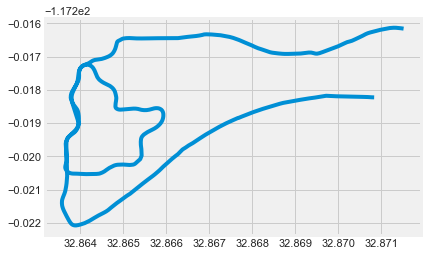

In [25]:
lat = gps_df['latitude']
long = gps_df['longitude']
plt.plot(lat, long)

In [26]:
gps_df.head()

,time,latitude,longitude,elevation
0,2022-08-03 19:09:12+00:00,32.870837,-117.218226,105.110916
1,2022-08-03 19:09:12+00:00,32.870837,-117.218226,105.114151
2,2022-08-03 19:09:13+00:00,32.870810,-117.218226,105.311157
3,2022-08-03 19:09:14+00:00,32.870782,-117.218224,105.511307
4,2022-08-03 19:09:15+00:00,32.870755,-117.218221,105.691582
